In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

## Load data and separate train from test-phase

There are cases where load and temp data are missing due to a blackout (see Known_Artifacts.md for an inexhaustive list)

We need to impute the temperature data to use it for training ARIMA-type models. We did NOT need this for the univariate model since complete data is only assumed for covariate (not the outcome).

In [2]:
base_data = pd.read_csv('data.csv', index_col=0)
base_data.index = pd.to_datetime(base_data.index)
base_data = base_data.asfreq('H')

imputed_data = base_data.copy()
for idx, row in imputed_data.iterrows():
    if np.isnan(row.tmp_f_KDFW):
        imputed_data.loc[idx].tmp_f_KDFW = base_data[
                                                    (base_data.index.month == idx.month) & 
                                                    (base_data.index.day == idx.day) & 
                                                    (base_data.index.hour == idx.hour)
                                                ].tmp_f_KDFW.mean()

In [8]:
train_data = imputed_data[imputed_data.index < '2021-07-01']
train_data = train_data.asfreq('H')
target_data = imputed_data[imputed_data.index >= '2021-07-01']
target_data = target_data.asfreq('H')

In [13]:
scaler = MinMaxScaler()
train_data[['tmp_f_KDFW', 'north_load']] = scaler.fit_transform(train_data[['tmp_f_KDFW', 'north_load']])

## ARIMA(24, 1, 6) Model

In [59]:
# Construct the model
mod = sm.tsa.SARIMAX(endog=train_data.north_load, exog=train_data.tmp_f_KDFW, order=(24, 1, 6), trend='ct')

# Estimate the parameters
res = mod.fit()

print(res.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96799D+00    |proj g|=  9.08370D+06


/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34      1     21      1     0     0   9.084D+06  -2.968D+00
  F =  -2.9679944578633690     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:              SARIMAX(24, 1, 6)   Log Likelihood              116962.726
Date:                Fri, 17 Jun 2022   AIC                        -233857.451
Time:                        15:55:02   BIC                        -233565.673
Sample:                    0

### Get Results Through 10/31/21

In [60]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:])

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

north_load                      mean   mean_se  mean_ci_lower  mean_ci_upper
2021-07-01 00:00:00-06:00  52.328379  0.012124      52.308437      52.348320
2021-07-01 01:00:00-06:00  51.968002  0.025139      51.926651      52.009352
2021-07-01 02:00:00-06:00  51.238206  0.036636      51.177945      51.298467
2021-07-01 03:00:00-06:00  50.655221  0.046503      50.578730      50.731712
2021-07-01 04:00:00-06:00  50.414254  0.055046      50.323712      50.504797
...                              ...       ...            ...            ...
2021-10-31 19:00:00-06:00  43.874530  1.443906      41.499516      46.249545
2021-10-31 20:00:00-06:00  42.189246  1.444152      39.813827      44.564664
2021-10-31 21:00:00-06:00  40.309508  1.444397      37.933685      42.685330
2021-10-31 22:00:00-06:00  38.235315  1.444643      35.859089      40.611541
2021-10-31 23:00:00-06:00  37.133393  1.444888      34.756763      39.510023

[2952 rows x 4 columns]


With trend = 'ct'

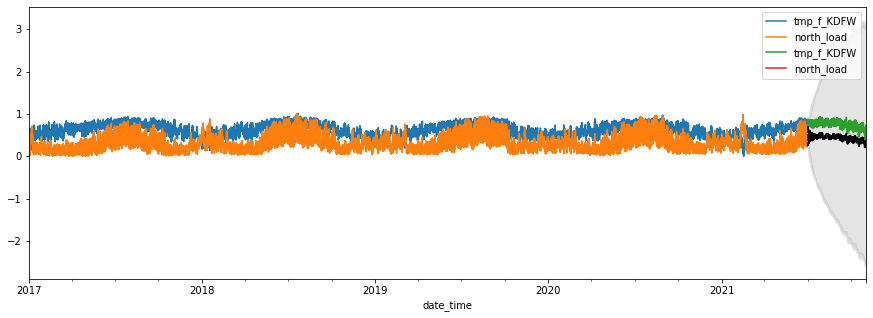

In [61]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2017-01-01':].plot(ax=ax)
target_trans = target_data.copy()
target_trans[['tmp_f_KDFW', 'north_load']] = scaler.transform(target_data[['tmp_f_KDFW', 'north_load']])
target_trans.plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1], exog=target_trans.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

With trend = 't'

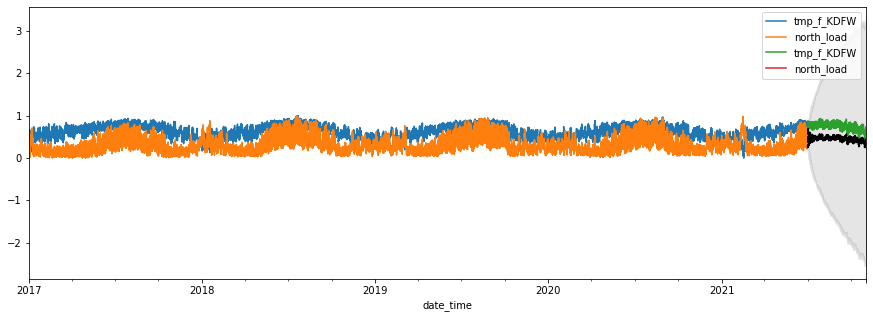

In [58]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2017-01-01':].plot(ax=ax)
target_trans = target_data.copy()
target_trans[['tmp_f_KDFW', 'north_load']] = scaler.transform(target_data[['tmp_f_KDFW', 'north_load']])
target_trans.plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1], exog=target_trans.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

With no trend

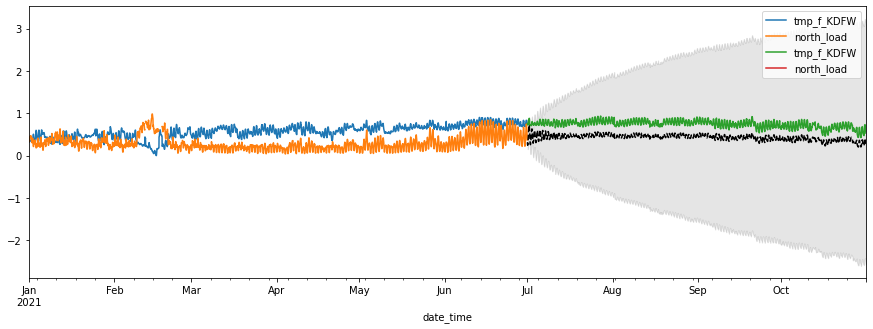

In [62]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2021-01-01':].plot(ax=ax)
target_trans = target_data.copy()
target_trans[['tmp_f_KDFW', 'north_load']] = scaler.transform(target_data[['tmp_f_KDFW', 'north_load']])
target_trans.plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1], exog=target_trans.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

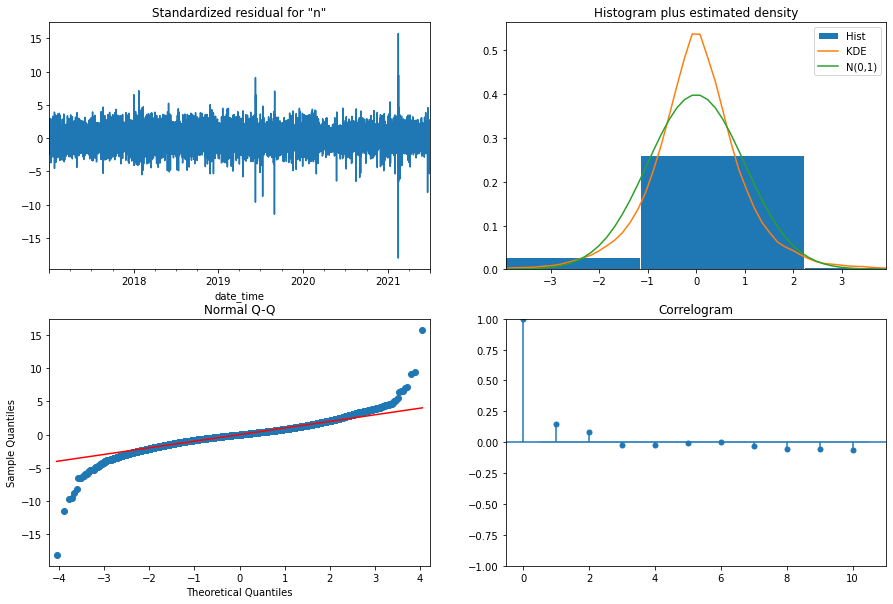

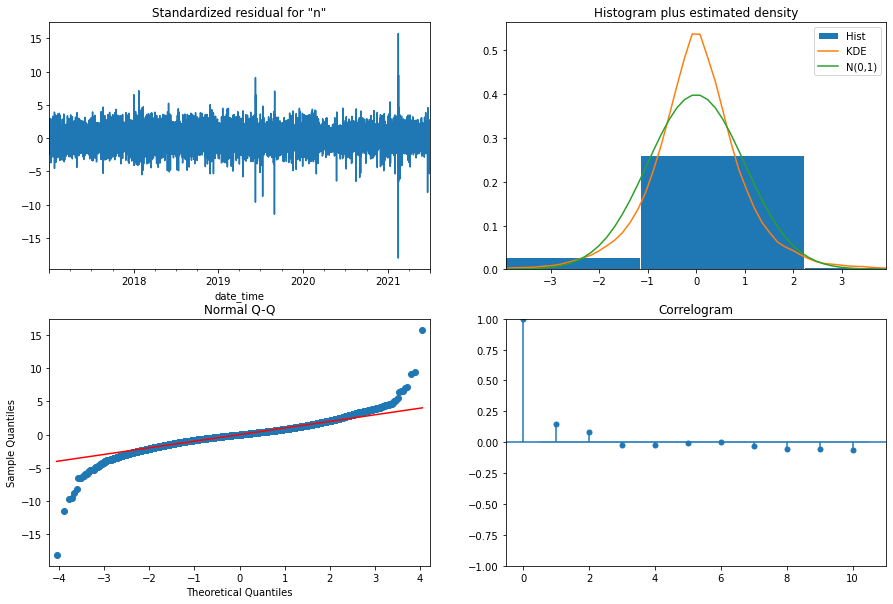

In [48]:
res.plot_diagnostics(figsize=(15,10))